In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define function to initialize "pretty" plots
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax

# The Morse Oscillator

A harmonic potential is only an adequate description of a bond energy near the minimum of the potential.  A better description of a bond potential is the Morse potential which is given as

$V(x) = D_e\left(1-e^{-\beta x}\right)^2$

where $D_e$ is the dissociation energy and $\beta$ controls the curvature of the potential.

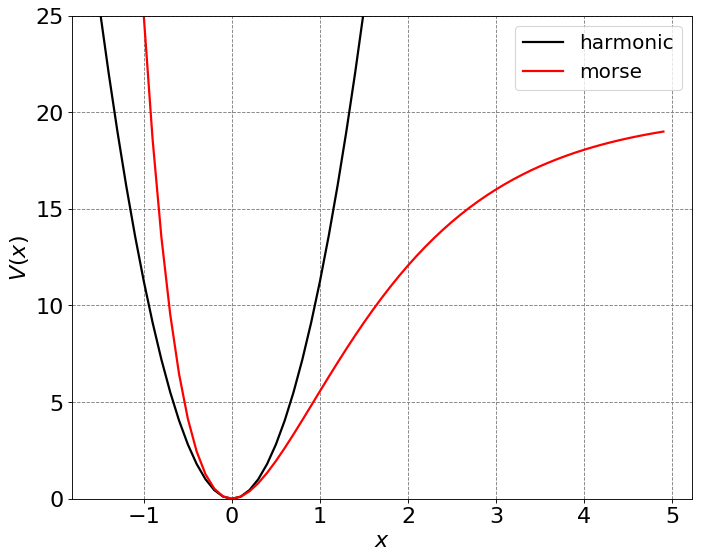

In [12]:
# plot morse potential and harmonic potential
De = 20.0
beta = 0.75
xvals = np.arange(-1.5,5,0.1)
# second order Taylor series expansion of Morse potential
def harmonic(x):
    return De*beta**2*x**2
def morse(x):
    return De*(1-np.exp(-beta*x))**2
ax = define_figure(xlabel="$x$",ylabel="$V(x)$")
# compute potential energies
U_h = harmonic(xvals)
U_morse = morse(xvals)
# plot potential energies
ax.plot(xvals, U_h, 'k',lw=2,label="harmonic")
ax.plot(xvals, morse(xvals), 'r',lw=2,label="morse")
ax.set_ylim(0,25)
plt.legend(fontsize=18)

The harmonic potential is the second order term in the Taylor series expansion of the morse potential.  Expanding around x=0 we have

$V(x) = \sum_{n=0}^\infty \frac{(x)^n}{n!}\frac{d^nV}{dx^n}|_{x=0}$

$ = D_e\beta^2x^2 - D_e\beta^3x^3 + \frac{7}{12}D_e\beta^4x^4+...$

If we compare the second order term to $1/2kx^2$ we can see that $1/2k = D_e\beta^2$.

One can include anharmonicity by adding additional components of the above expansion of the Morse potential in the potential.  A homework problem is to derive the variational matrix elements in a guassian basis for the third order term.   It is possible (if not annoying) to do this for arbitrary order in the Taylor series expansion.  Instead we use numeric integration techniques to solve those elements for ease and adaptability of the code (note that we use derived matrix elements for the kinetic energy).  We will show you what this looks like for including up to fourth order in the above expansion as well as using the Morse potential directly.  

## The code

In [4]:
# code to perform Variational principle solution to expansion of wavefunctions in a gaussian basis to K+V Hamiltonian in 1D
from scipy import integrate

# integrand for potential component of Hamiltonian matrix element for gaussian basis functions
def integrand(x,V,xi,xj,alpha):
    return np.exp(-alpha*(x-xi)**2)*V(x)*np.exp(-alpha*(x-xj)**2)

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def basis_V(N,V,xvals=np.arange(-4,4,0.1)):
    #N = 3                       # half the number of basis functions
    K = 2*N+1                    # total number of basis functions
    dx = 0.4                     # spacing between basis functions
    alpha = 1.0                  # 1/spread of basis functions
    xmin = -N*dx                 # minimum x value for basis functions
    xIntegrand = np.arange(xmin-1.0/alpha*10,abs(xmin)+1.0/alpha*10,0.01)
    S = np.zeros((K,K),dtype=float)   # basis function overlap matrix
    H = np.zeros((K,K),dtype=float)   # Hamiltonian matrix, Hij = <Si|H|Sj>

    # populate the basis function, S, and Hamiltonian, H, matrices
    for i in range(K):
        xi = xmin + (i-1)*dx
        for j in range(K):
            xj = xmin + (j-1)*dx
            # basis function value:
            # Ostlund and Szabo page 47
            S[i,j] = np.sqrt(0.5*np.pi/alpha)*np.exp(-0.5*alpha*(xi-xj)**2)
            # Hamiltonian value (standard Harmonic Oscillator matrix element - applied to basis functions)
            H[i,j] = 0.5*S[i,j]*(alpha - (alpha**2)*(xi-xj)**2) # Kinetic energy
#            H[i,j] += integrate.quad(integrand,-np.inf,np.inf,args=(V,xi,xj,alpha))[0] # potential energy using numeric integration
            H[i,j] += integrate.simps(integrand(xIntegrand,V,xi,xj,alpha),xIntegrand)
    # finalize the S^-1*H*S matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these so largest eigenvalue is first
    idx = H_eig_val.argsort()   
    H_eig_val = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]

    nx = xvals.size
    psi = np.zeros((nx,K),dtype=float)
    # generate psis from coefficients
    for A in range(K):
        count = K-A-1
        for i in range(K):
            xi = xmin + (i-1)*dx
            psi[:,A] = psi[:,A] + H_eig_vec[i,A]*np.exp(-alpha*(xvals-xi)**2)
    
        # normalize the wavefunctions
        psi2 = psi[:,A]**2
        norm = integrate.simps(psi2,xvals)
        psi[:,A] /= np.sqrt(norm)
    # return normalized wavefunctions and energies
    return psi, H_eig_val

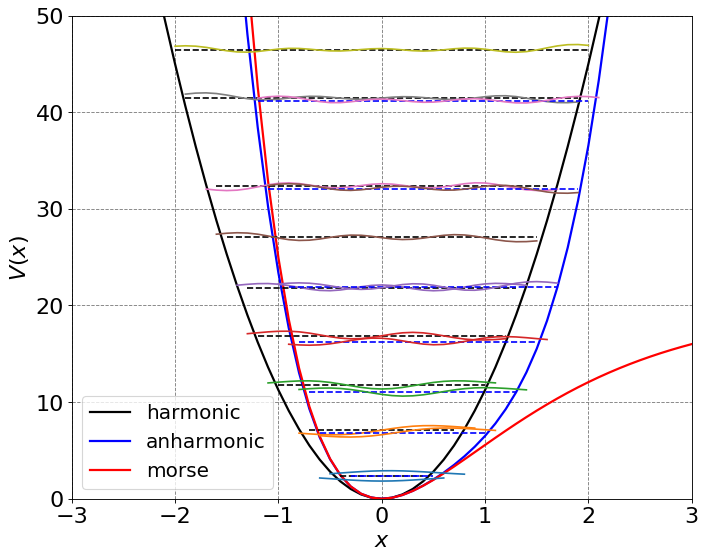

In [17]:
# This code will compute the Harmonic and Anharmonic Oscillator solutions using the Variational gaussian basis routine above

De = 20.0
beta = 0.75
xvals = np.arange(-4,4,0.1)

# second order Taylor series expansion of Morse potential
def harmonic(x):
    return De*beta**2*x**2
# fourth order Taylor series expansion of Morse potential
def anharmonic(x):
    return De*beta**2*x**2 - De*beta**3*(x)**3 + 7./12.*De*beta**4*x**4


#fig, ax = plt.subplots(figsize=(12,8))
# initialize a figure
ax = define_figure(xlabel="$x$",ylabel="$V(x)$")
# compute potentials
U_h = harmonic(xvals)
U_ah = anharmonic(xvals)
# plot potentials
ax.plot(xvals, U_h, 'k',lw=2,label="harmonic")
ax.plot(xvals, U_ah, 'b',lw=2,label="anharmonic")
ax.plot(xvals, morse(xvals), 'r',lw=2,label="morse")
# calculate wavefunctions and energy levels using variational principle and basis functions:
psi_h, E_h = basis_V(18,harmonic,xvals)
psi_ah, E_ah = basis_V(18,anharmonic,xvals)
# plot harmonic energy levels and wavefunctions
for n in range(10):
    # plot the energy level
    mask = np.where(E_h[n] > U_h)  
    ax.plot(xvals[mask], E_h[n] * np.ones(np.shape(xvals))[mask], 'k--')
    # plot the wavefunction
    Y = psi_h[:,n]/2.0+E_h[n]
    mask = np.where(Y > U_h-2.0)
    ax.plot(xvals[mask], Y[mask].real)
# plot anharmonic energy levels and wavefunctions
for n in range(10):
    # plot the energy level
    mask = np.where(E_ah[n] > U_ah)  
    ax.plot(xvals[mask], E_ah[n] * np.ones(np.shape(xvals))[mask], 'b--')
    # plot the wavefunction
    Y = psi_ah[:,n]/2.0+E_ah[n]
    mask = np.where(Y > U_ah-2.0)
    ax.plot(xvals[mask], Y[mask].real)      
ax.set_xlim(-3, 3)
ax.set_ylim(0, 50)
ax.legend(loc=3,fontsize=18)

/Users/martinmccullagh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


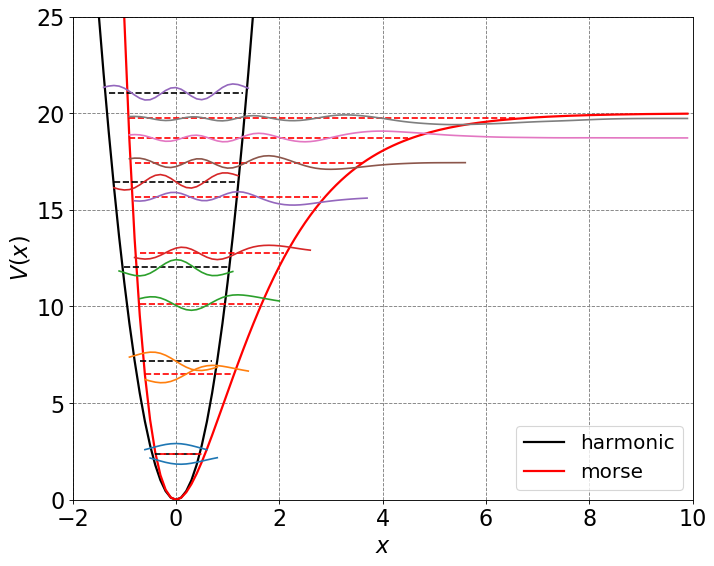

In [9]:
De = 20.0
beta = 0.75
xvals = np.arange(-3,10,0.1)

def harmonic(x):
    return De*beta**2*x**2

def morse(x):
    return De*(1-np.exp(-beta*x))**2

#fig, ax = plt.subplots(figsize=(12,8))
# initialize a figure
ax = define_figure(xlabel="$x$",ylabel="$V(x)$")
# compute potential energies
U_h = harmonic(xvals)
U_morse = morse(xvals)
# plot potential energies
ax.plot(xvals, U_h, 'k',lw=2,label="harmonic")
ax.plot(xvals, morse(xvals), 'r',lw=2,label="morse")
# compute wavefunctions and energies for these potential functions
psi_h, E_h = basis_V(18,harmonic,xvals)
psi_morse, E_morse = basis_V(18,morse,xvals)
# plot harmonic energy levels and wavefunctions
for n in range(10):
    # plot the energy level
    mask = np.where(E_h[n] > U_h)  
    ax.plot(xvals[mask], E_h[n] * np.ones(np.shape(xvals))[mask], 'k--')
    # plot the wavefunction
    Y = psi_h[:,n]/2.0+E_h[n]
    mask = np.where(Y > U_h-2.0)
    ax.plot(xvals[mask], Y[mask].real)
# plot morse energy levels and wavefunctions
for n in range(10):
    if (E_morse[n] <= De):
        # plot the energy level
        mask = np.where(E_morse[n] > U_morse)  
        ax.plot(xvals[mask], E_morse[n] * np.ones(np.shape(xvals))[mask], 'r--')
        # plot the wavefunction
        Y = psi_morse[:,n]/2.0+E_morse[n]
        mask = np.where(Y > U_morse-2.0)
        ax.plot(xvals[mask], Y[mask].real)     
ax.set_xlim(-2, 10)
ax.set_ylim(0, 25)
ax.legend(loc=4,fontsize=18)